In [86]:
import glob
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt


In [87]:
moods = ['calm', 'energetic', 'happy', 'sad']
X = []
y = []
for mood in moods:
    c=0
    path = f"./mp3s/{mood}/*.mp3"
    for fname in glob.glob(path):
        waveform, sr = librosa.load(fname)
        waveform = librosa.resample(waveform, sr, 22050)
        if mood == 'calm':
            enc = 0
        elif mood == 'energetic':
            enc = 1
        elif mood == 'happy':
            enc = 2
        elif mood == 'sad':
            enc = 3
        X.append(waveform)
        y.append(enc)
        c+=1
        if c>10:
            print(mood + " complete.")
            break

calm complete.
energetic complete.
happy complete.
sad complete.


In [121]:
pad_X = []
for i in X:
    if len(i) == 661501:
        pad_X.append(i)
    elif len(i) == 661500:
        p = np.random.choice(i[-100:])
        padded = np.append(i, p)
        pad_X.append(padded)
X = np.asarray(pad_X)
y = np.asarray(y)

In [89]:
## TOTAL SONG COUNT:
(X[20])

array([-0.06064668, -0.14683361, -0.16937134, ..., -0.00347758,
       -0.19777964, -0.23535028], dtype=float32)

calm


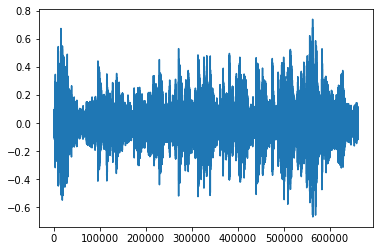

In [90]:
rand_song_ind = 3

mood_dict = {0: 'calm', 1: 'energetic', 2: 'happy', 3: 'sad'}
print(mood_dict[y[rand_song_ind]])
plt.plot(X[rand_song_ind].T)

In [91]:
sr = 22050
print(mood_dict[y[rand_song_ind]])
ipd.Audio(X[rand_song_ind], rate = sr)

calm


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

# tqdm to enable progress bars for training and testing loops
from tqdm.notebook import tqdm


from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


<AxesSubplot:>

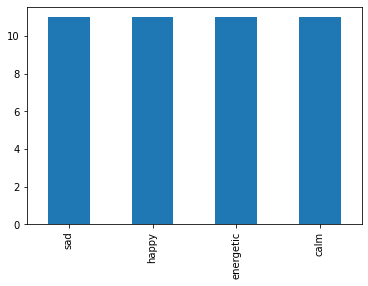

In [93]:
df = pd.DataFrame(zip(X,y), columns = ['audio', 'mood'])
df['mood'].replace(mood_dict, inplace=True)
df['mood'].value_counts().plot.bar()

<AxesSubplot:ylabel='mood'>

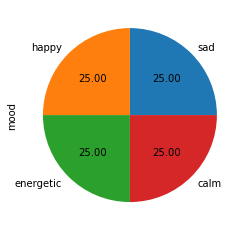

In [94]:
df['mood'].value_counts().plot.pie(autopct='%.2f')

In [136]:
# Split into train+val and test
X_trainval, x_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
x_train, x_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [137]:
# Normalize Input
scaler = MinMaxScaler()
X_train = []
X_val = []
X_test = []

for i in x_train:
    X_train.append(scaler.fit_transform(i.reshape(-1, 1)).reshape(1, -1)[0])
for i in x_val:
    X_val.append(scaler.transform(i.reshape(-1, 1)).reshape(1, -1)[0])
for i in x_test:
    X_test.append(scaler.transform(i.reshape(-1, 1)).reshape(1, -1)[0])
X_train, y_train = np.asarray(X_train)[:, np.newaxis], np.asarray(y_train)[:, np.newaxis]
X_val, y_val = np.asarray(X_val)[:, np.newaxis], np.asarray(y_val)[:, np.newaxis]
X_test, y_test = np.asarray(X_test)[:, np.newaxis], np.asarray(y_test)[:, np.newaxis]

In [ ]:
#These need to be one hot encodesd

In [210]:
y_test[0:10]

array([[1],
       [0],
       [2],
       [3],
       [0],
       [2],
       [1],
       [3],
       [2]])

In [97]:
# Visualize Class Distribution in Train, Val, and Test
def get_class_distribution(obj):
    count_dict = {
        "calm": 0,
        "energetic": 0,
        "happy": 0,
        "sad": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['calm'] += 1
        elif i == 1: 
            count_dict['energetic'] += 1
        elif i == 2: 
            count_dict['happy'] += 1
        elif i == 3: 
            count_dict['sad'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

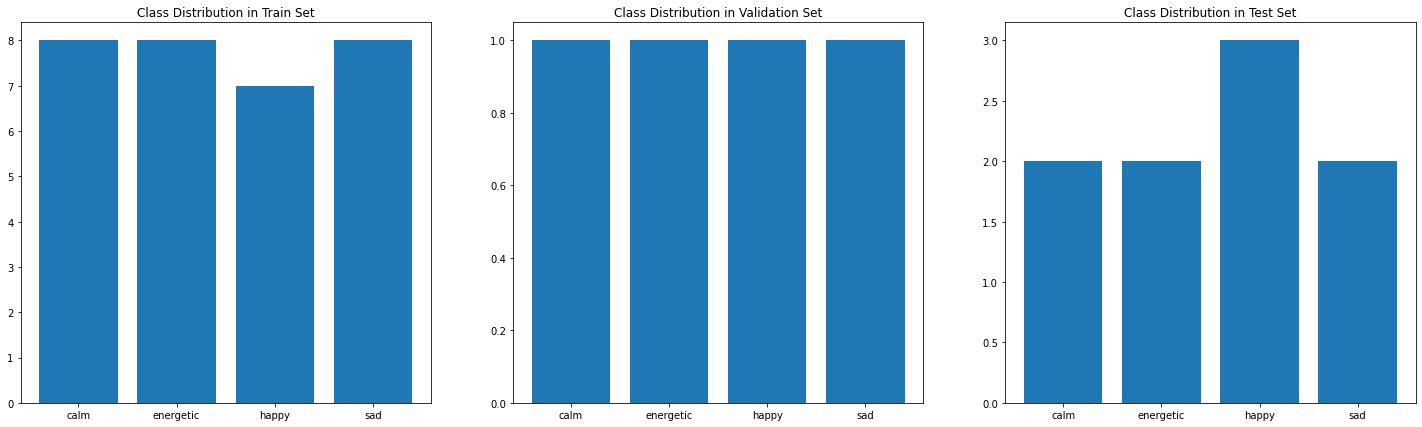

In [98]:
train_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt()
validation_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt()
test_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
axes[0].bar(train_count_df["variable"], train_count_df["value"])
axes[0].set_title('Class Distribution in Train Set')

# Validation
axes[1].bar(validation_count_df["variable"], validation_count_df["value"])
axes[1].set_title('Class Distribution in Validation Set')

# Test
axes[2].bar(test_count_df["variable"], test_count_df["value"])
axes[2].set_title('Class Distribution in Test Set')


In [99]:
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

#train_dataset = ClassifierDataset(X_train, torch.from_numpy(y_train).long())
#val_dataset = ClassifierDataset(X_val, torch.from_numpy(y_val).long())
#test_dataset = ClassifierDataset(X_test, torch.from_numpy(y_test).long())

# for imbalanced data

In [100]:
# Weighted Sampling
# First, we obtain a list called target_list which contains all our outputs. 
# This list is then converted to a tensor and shuffled.
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [101]:
# Then, we obtain the count of all classes in our training set. 
# We use the reciprocal of each count to obtain it’s weight.
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([0.1250, 0.1250, 0.1429, 0.1250])


In [102]:
# WeightedRandomSampler expects a weight for each sample. 
class_weights_all = class_weights[target_list]

In [103]:
# initialize our WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

# Model Parameters

In [148]:
EPOCHS = 3
BATCH_SIZE = 2
LEARNING_RATE = 0.1
NUM_FEATURES = len(X[0])
NUM_CLASSES = 4

# Dataloader

In [149]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# Define Neural Net Architecture


In [106]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
#         self.batchnorm1 = nn.BatchNorm1d(512)
#         self.batchnorm2 = nn.BatchNorm1d(128)
#         self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
#         x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
#         x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
#         x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [150]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [108]:
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [203]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 4


In [204]:
# Initialize the model, optimizer, and loss function. 
# Transfer the model to GPU. 
# We’re using the nn.CrossEntropyLoss because this is a multiclass classification problem. 
# We don’t have to manually apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. 
# However, we need to apply log_softmax for our validation and testing.

#model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([4, 32])
torch.Size([4])


In [205]:
# function to calculate accuracy per epoch
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [206]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [207]:
for a, b in train_loader:
    print(a.swapaxes(1,2).shape, b.shape)

torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([2, 661501, 1]) torch.Size([2, 1])
torch.Size([1, 661501, 1]) torch.Size([1, 1])


In [208]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.swapaxes(1,2).to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        print(y_train_pred.shape)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.swapaxes(1,2).to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            print(y_val_pred.shape)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([2, 4])


RuntimeError: 1D target tensor expected, multi-target not supported

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

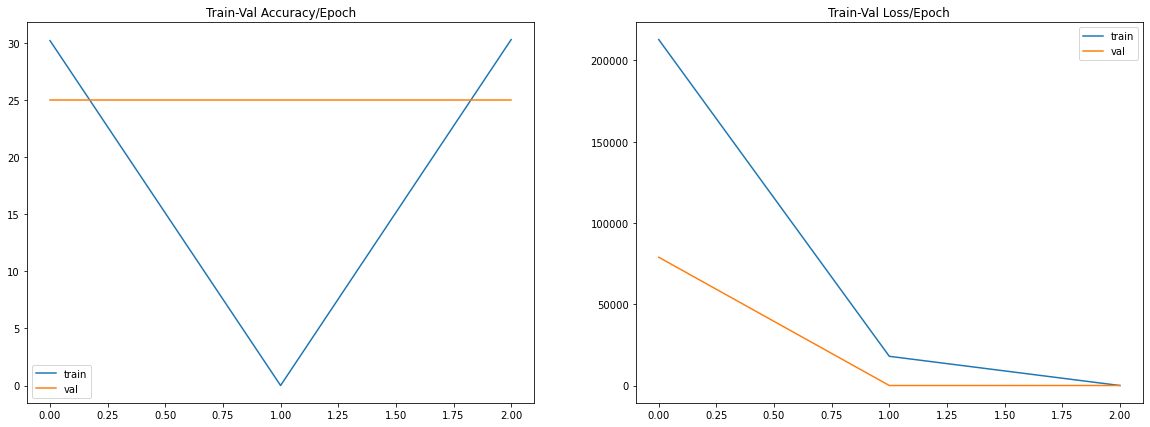

In [40]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
axes[0].plot(train_val_acc_df[train_val_acc_df["variable"]=='train']["epochs"], train_val_acc_df[train_val_acc_df["variable"]=='train']["value"],label = "train")
axes[0].plot(train_val_acc_df[train_val_acc_df["variable"]=='val']["epochs"], train_val_acc_df[train_val_acc_df["variable"]=='val']["value"],label = "val")
axes[0].set_title('Train-Val Accuracy/Epoch')
axes[0].legend()

axes[1].plot(train_val_loss_df[train_val_loss_df["variable"]=='train']["epochs"], train_val_loss_df[train_val_loss_df["variable"]=='train']["value"],label = "train")
axes[1].plot(train_val_loss_df[train_val_loss_df["variable"]=='val']["epochs"], train_val_loss_df[train_val_loss_df["variable"]=='val']["value"],label = "val")
axes[1].legend()
axes[1].set_title('Train-Val Loss/Epoch')

# Test the model

In [291]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

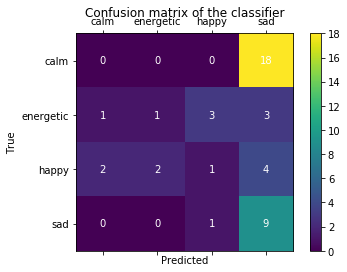

In [292]:
cm = confusion_matrix(y_test, y_pred_list)
confusion_matrix_df = pd.DataFrame(cm).rename(columns=mood_dict, index=mood_dict)
labels = confusion_matrix_df.columns.tolist()
# plt.imshow(confusion_matrix_df)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()

In [293]:
confusion_matrix_df

,calm,energetic,happy,sad
calm,0,0,0,18
energetic,1,1,3,3
happy,2,2,1,4
sad,0,0,1,9


In [294]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.33      0.12      0.18         8
           2       0.20      0.11      0.14         9
           3       0.26      0.90      0.41        10

    accuracy                           0.24        45
   macro avg       0.20      0.28      0.18        45
weighted avg       0.16      0.24      0.15        45

